# Gaussian fit to the spectra of ALMA H$_2$CO($3_{0,3} - 2_{0,2}$)


In [1]:
%matplotlib inline
import pyspeckit
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from skimage.morphology import remove_small_objects, closing, disk, opening, remove_small_holes, dilation
import os
import sys
sys.path.append('../../B5_NOEMA_30m')
import matplotlib.pyplot as plt
import aplpy
from B5setup import *
from scipy.interpolate import griddata

block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


## Preparation of the data

This part must be run for any of the independent sections to work

In [2]:
imagefile_original = "B5IRS1_H2COa_robust05_multi_3_cut.fits" # we will use the non-pbcor
imagefile = "B5IRS1_H2COa_robust05_multi_3_cut_K"
imagefilecorr = imagefile + '_contcorrected'
imagefilecontinuum = imagefile + '_continuum.fits'

rmsfile = imagefilecorr + '_rms'
snrfile = imagefilecorr + '_snr'
tpeakfile = imagefilecorr + '_Tpeak'

maskfile = imagefilecorr + '_mask'

fitfile2G =  imagefilecorr + '_2G_fitparams.fits'
fitfile =  imagefilecorr + '_1G_fitparams.fits'
initguessfile = fitfile
newguessfile = imagefilecorr + '_1G_fitparams_guesses.fits'
fitfile2 = imagefilecorr + '_1G_fitparams_2.fits'
fitfile2filtered = imagefilecorr + '_1G_fitparams_2_filtered.fits'
fitfile2filteredTpeak = imagefilecorr + '_1G_fitparams_2_filtered_Tpeak.fits'
fitfile2filteredVlsr = imagefilecorr + '_1G_fitparams_2_filtered_Vlsr.fits'
fitfile2filteredSigmaV = imagefilecorr + '_1G_fitparams_2_filtered_SigmaV.fits'

fitfile2sigmafiltered = imagefilecorr + '_1G_fitparams_2_sigmafiltered.fits'
fitfile2sigmafilteredTpeak = imagefilecorr + '_1G_fitparams_2_sigmafiltered_Tpeak.fits'
fitfile2sigmafilteredVlsr = imagefilecorr + '_1G_fitparams_2_sigmafiltered_Vlsr.fits'
fitfile2sigmafilteredSigmaV = imagefilecorr + '_1G_fitparams_2_sigmafiltered_SigmaV.fits'
fitfile2sigmafilteredSigmaNT = imagefilecorr + '_1G_fitparams_2_sigmafiltered_SigmaNT.fits'
fitfile2sigmafilteredMachs = imagefilecorr + '_1G_fitparams_2_sigmafiltered_Mach_s.fits'

# Where we estimate the line is
velinit = 8.0
velend = 12.5
velinitrms = 5.9
starting_point = (141,139) #x, y
snratio = 5
multicore = 40
maxsigma = 0.31 #0.45
minsizetrim = 50

In [3]:
# convert the file from Jy/beam to k
if not os.path.exists(imagefile+'.fits'):
    imagecube = SpectralCube.read(imagefile_original).with_spectral_unit(u.km/u.s)
    kelvincube = imagecube.to(u.K)
    kelvincube.hdu.writeto(imagefile+'.fits')

In [4]:
# we try the continuum corrected fitting

cube = SpectralCube.read(imagefile + '.fits')

if not os.path.exists(imagefilecorr + '.fits'):
    print('Creating continuum correct')
    spectral_axis = cube.spectral_axis
    good_channels = (spectral_axis < 7.8 * u.km / u.s) | (spectral_axis > 12.5 * u.km / u.s)  
    masked_cube = cube.with_mask(good_channels[:, np.newaxis, np.newaxis])  
    med = masked_cube.median(axis=0)
    if not os.path.exists(imagefilecontinuum):
        med.write(imagefilecontinuum)
    med_subcube = cube - med
    med_subcube.write(imagefilecorr + '.fits')
else:
    med_subcube = SpectralCube.read(imagefilecorr + '.fits')
    
cube = pyspeckit.Cube(imagefilecorr + '.fits')


In [5]:
header = cube.header
hdcube = cube.header.copy()
key_remove = ['NAXIS3','CRPIX3','CDELT3','CUNIT3','CTYPE3','CRVAL3','SPECSYS']
for key_i in key_remove:
    hdcube.remove(key_i)
hdcube['WCSAXES'] = 2
hdcube['NAXIS'] = 2

if not os.path.exists(rmsfile+'.fits'):
    rmsmap = cube.slice(velinitrms, velinit, unit='km/s').cube.std(axis=0)
    fits.writeto(rmsfile+'.fits', rmsmap, hdcube)
    print('Created RMS file')
else:
    rmsmap = fits.getdata(rmsfile+'.fits')

if not os.path.exists(tpeakfile+'.fits'):
    Tpeakmap = cube.slice(velinit, velend, unit='km/s').cube.max(axis=0)
    fits.writeto(tpeakfile+'.fits', Tpeakmap, hdcube)
    print('Created Tpeak file')
else:
    Tpeakmap = fits.getdata(tpeakfile+'.fits')

if not os.path.exists(snrfile+'.fits'):
    snrmap = Tpeakmap / rmsmap
    hdcubesnr = hdcube.copy()
    hdcubesnr['BUNIT'] = ''
    fits.writeto(snrfile+'.fits', snrmap, hdcubesnr)
    print('Created SNR file')
else:
    snrmap = fits.getdata(snrfile+'.fits')

if not os.path.exists(maskfile+'.fits'):
    planemask = (snrmap > snratio)
    # check the resulting mask map to see how much does the minimum size have to be and its connectivity
    # before applying this filter
    planemask = remove_small_objects(planemask, min_size=minsizetrim)
    planemask = remove_small_holes(planemask, area_threshold=minsizetrim)
    planemask = closing(planemask, disk(3))
    planemask = remove_small_holes(planemask, area_threshold=minsizetrim*4)
    planemask = opening(planemask, disk(4))
    hdcube['WCSAXES'] = 2
    hdcube['NAXIS'] = 2
    hdcube['BUNIT'] = ''
    fits.writeto(maskfile+'.fits', planemask.astype(int), hdcube)
    print('Created Mask file')
else:
    planemask = fits.getdata(maskfile+'.fits')

print('Loaded initial files: Tpeak, rms, SNR')
    

Loaded initial files: Tpeak, rms, SNR


## Functions

These functions will allow to filter and interpolate solutions. Also must be run for the independent sections to work

### Quality assessment filter for Gaussian fittings

In [6]:
def filtersolutions(parcube, errcube, npeaks, rmsmap=None, snratio=None, velinit=-np.inf, velend=np.inf, filter_negative=False, errorfrac=None, eps=1.e-6, filter_islands=False, minsizetrim=50):
    """
    Replace the pixels in the fitted cube with np.nan where the fit is not
    good enough according to our criteria.

    The criteria that a pixel must have are:
    - The errors are not zero (less than eps)
    - The peak must not be negative in case filter_negatives is true
    - The error fraction is lower than errorfrac, if given
    - The central velocity value must be within the range [velinit,velend]
    - The peak value must be larger than rms times snratio, if given
    - If one parameter in a spectra is np.nan, all the spectra must be nan (sanity
    check)

    Args:
        variable (type): description

    Returns:
        type: description

    Raises:
        Exception: description

    """
    # we first create all the masks we need
    
    # all errors must be non zero
    # note that eps must be larger than the velocity dispersion
    zeromask = np.zeros(np.shape(parcube[0]), dtype=int) # we need to do a plane mask
    for i in range(3*npeaks):
        zeromask += np.where(np.abs(errcube[i])<eps, 1, 0)
        
    # if a fraction is given, make sure all values have an error fraction less than that
    errormask = np.zeros(np.shape(parcube[0]), dtype=int)
    if errorfrac is not None:
        for i in range(3*npeaks):
            errormask += np.where(np.abs(errcube[i]/parcube[i]) > errorfrac, 1, 0)
            
    
    # if indicated, all values must be non-negative
    negativemask = np.zeros(np.shape(zeromask), dtype=int)
    if filter_negative:
        for i in range(3*npeaks):
            negativemask += np.where(parcube[i] < 0, 1, 0)
    
    # velocities must be within range
    velocitymask = np.zeros(np.shape(zeromask), dtype=int)
    for i in range(npeaks):
        velocitymask += np.where(parcube[1+3*i] < velinit, 1, 0) + \
        np.where(parcube[1+3*i] > velend, 1, 0)
    
    # the amplitude of the Gaussian must be above the snratio indicated
    peakmask = np.zeros(np.shape(zeromask), dtype=int)
    if snratio is not None and rmsmap is not None:
        for i in range(npeaks):
            snrmappeak = parcube[3*i] / rmsmap
            peakmask += np.where(snrmappeak < snratio, 1, 0)
    
    # all values of parameters and uncertainties must be not NaN
    nanmask = np.zeros(np.shape(zeromask), dtype=int)
    for i in range(3*npeaks):
        nanmask += np.where(np.isnan(parcube[i]), 1, 0) + np.where(np.isnan(errcube[i]), 1, 0)
    
    
    finalmask = zeromask + errormask + negativemask + velocitymask + peakmask + nanmask
    
    parcubenew = parcube.copy()
    errcubenew = errcube.copy()
    parcubenew[np.where(np.repeat([finalmask], 3*npeaks, axis=0))] = np.nan
    errcubenew[np.where(np.repeat([finalmask], 3*npeaks, axis=0))] = np.nan   
    
    # eliminate isolated small islands of emission after the filter
    if filter_islands:        
        planemask = ~np.isnan(parcubenew[0])
        planemask = remove_small_objects(planemask, min_size=minsizetrim)
        smallmask = np.ones(np.shape(planemask), dtype=int) - planemask
        parcubenew[np.where(np.repeat([smallmask], 3*npeaks, axis=0))] = np.nan
        errcubenew[np.where(np.repeat([smallmask], 3*npeaks, axis=0))] = np.nan
    
    return parcubenew, errcubenew


### Interpolation of parameters to obtain improved initial guesses

In [7]:
# as each plane represents a different physical characteristic, and they do not necessarilly 
# correlate between each other, each plane of initguesses must be fit separately
def interpolatesolutions(solfilein, npeaks, mask=None):
    '''
    The solfilein must be a .fits file that contains one parameter per 
    plane and then one parameter uncertainty per plane.
    The shape must be [nplane, yy, xx]
    '''
    solcube = fits.getdata(solfilein)[:3*npeaks]
    if np.any(np.isnan(solcube)):
        solcube[np.where(np.isnan(solcube))] = 0
    solcubeshape = np.shape(solcube)
    yy, xx = np.indices(solcubeshape[1:])
    filledcube = solcube.copy()
    headersolcube = fits.getheader(solfilein)

    for i, plane in enumerate(solcube):
        indexknown = np.where(plane<1e-5, False, True)
        filledcube[i][~indexknown] = griddata((xx[indexknown], yy[indexknown]),
                                                  plane[indexknown],
                                                  (xx[~indexknown], yy[~indexknown])
                                                 )
        if mask is not None:
            filledcube[i][np.where(mask==0)] = np.nan
    return filledcube, headersolcube


## 1 Gaussian fit

### First fit: initial guesses fixed

In [8]:
# initial guesses for the first two gaussian fit
initguesses = [10.0, 10.2, 0.8]
limitedmin = [True, True, True]
limitedmax = [False, True, False]
limitsmin = [0, velinit, 0]
limitsmax = [0, velend, velend-velinit]

if not os.path.exists(fitfile):
    print("Starting fit")
    cube.fiteach(fittype='gaussian',
                 guesses=initguesses,
                 signal_cut=snratio,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit exists. Loading")
    cube.load_model_fit(fitfile, 3, fittype='gaussian')

Fit exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.


### Second fit: Extrapolation

We do not do a quality assesment yet. We extrapolate the best fit results to fill in the gaps in the mask

In [9]:
if not os.path.exists(newguessfile):
    print("Interpolating previous solutions.")
    newinitguess, headerguess = interpolatesolutions(initguessfile, 1, mask=planemask)
    fits.writeto(newguessfile, newinitguess, headerguess)
    
else:
    print("Interpolation exists. Loading.")
    newinitguess = fits.getdata(newguessfile)
    
if not os.path.exists(fitfile2):
    print("Starting fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose_level=1,
                 multicore=multicore)
    cube.write_fit(fitfile2)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile2, 3, fittype='gaussian')

Interpolation exists. Loading.
Fit 2 exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.


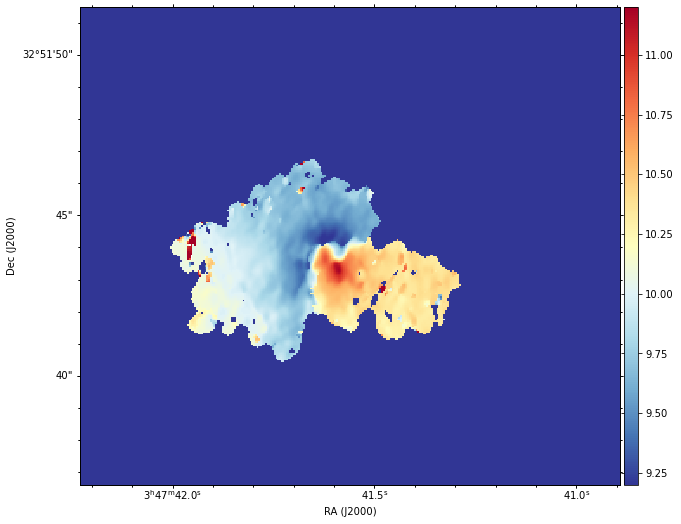

In [10]:
# first look at the velocities before filtering
gc = aplpy.FITSFigure(fits.PrimaryHDU(cube.parcube[1], hdcube))
gc.show_colorscale(cmap='RdYlBu_r', vmin=9.2, vmax=11.2)
gc.add_colorbar()
# gc.show_contour('../cont_image/B5IRS1_cont_natural.fits', colors='w', levels=0.00005*np.array([5, 15, 25]))

Do not let the apparent red-blue rotation within the continuum distract you, there might be two gaussian components or a strong self-absorption for what can be seen in the spectra there (see view_gaussfit_interactive.py)

### Quality Assesment

In [11]:
# we apply the filter
if not os.path.exists(fitfile2filtered):
    print("Creating filtered version.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 1, rmsmap=rmsmap, snratio=3, velinit=velinit, velend=velend, filter_negative=True, errorfrac=0.5)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile2filtered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading filtered version.")
    cube.load_model_fit(fitfile2filtered, 3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()

    
if not os.path.exists(fitfile2filteredTpeak):
    print("Saving Tpeak fit (filtered)")
    hdcube['BUNIT'] = 'K'
    fits.writeto(fitfile2filteredTpeak, cube.parcube[0], hdcube)
    
if not os.path.exists(fitfile2filteredVlsr):
    print("Saving Vlsr fit (filtered)")
    hdcube['BUNIT'] = 'km s-1'
    fits.writeto(fitfile2filteredVlsr, cube.parcube[1], hdcube)
    
if not os.path.exists(fitfile2filteredSigmaV):
    print("Saving SigmaV fit (filtered)")
    hdcube['BUNIT'] = 'km s-1'
    fits.writeto(fitfile2filteredSigmaV, cube.parcube[2], hdcube)


Loading filtered version.
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan] to [nan, nan, nan]


In [12]:
# we also apply a filter where we eliminate all curves with sigma larger than xx km/s

if not os.path.exists(fitfile2sigmafiltered):
    print("Filtering curves with sigma_v>"+str(maxsigma)+' km/s')
    sigmamask = np.where(cube.parcube[2]>maxsigma, 1, 0)
    cube.parcube[np.where(np.repeat([sigmamask], 3, axis=0))] = np.nan
    cube.errcube[np.where(np.repeat([sigmamask], 3, axis=0))] = np.nan
    cube.write_fit(fitfile2sigmafiltered)
    fittedmodel = cube.get_modelcube()
    
else:
    print("File with sigma_v>"+str(maxsigma)+' km/s filtered exists')
    cube.load_model_fit(fitfile2sigmafiltered, 3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    
# save the different parameters in individual fits for more comfortable use

if not os.path.exists(fitfile2sigmafilteredTpeak):
    print("Saving Tpeak fit (sigma filtered)")
    hdcube['BUNIT'] = 'K'
    fits.writeto(fitfile2sigmafilteredTpeak, cube.parcube[0], hdcube)
    
if not os.path.exists(fitfile2sigmafilteredVlsr):
    print("Saving Vlsr fit (sigma filtered)")
    hdcube['BUNIT'] = 'km s-1'
    fits.writeto(fitfile2sigmafilteredVlsr, cube.parcube[1], hdcube)
    
if not os.path.exists(fitfile2sigmafilteredSigmaV):
    print("Saving SigmaV fit (sigma filtered)")
    hdcube['BUNIT'] = 'km s-1'
    fits.writeto(fitfile2sigmafilteredSigmaV, cube.parcube[2], hdcube)


File with sigma_v>0.31 km/s filtered exists
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan] to [nan, nan, nan]


## 2 Gaussian fit

Motivated by the results of the first fit, we explore what is going on in the center, where we masked before. We can find resolved structures if we explore a 2 Gaussian fit

In [13]:
snratio = 5

imagefilecorr = imagefile + '_contcorrected'
imagefilecontinuum = imagefile + '_continuum.fits'
fitfile2G =  imagefilecorr + '_2G_fitparams.fits'
fitfile2Gfiltered =  imagefilecorr + '_2G_fitparams_filtered.fits'
initguessfile2G = fitfile2Gfiltered
newguessfile2G = imagefilecorr + '_2G_fitparams_guesses.fits'
fitfile22G = imagefilecorr + '_2G_fitparams_2.fits'
fitfile22Gfiltered = imagefilecorr + '_2G_fitparams_2_filtered.fits'
initguessfile22G = fitfile22Gfiltered
newguessfile22G = imagefilecorr + '_2G_fitparams_2_guesses.fits'
fitfile32G = imagefilecorr + '_2G_fitparams_3.fits'
fitfile32Gfiltered = imagefilecorr + '_2G_fitparams_3_filtered.fits'

fitfile22GfilteredTpeak = imagefilecorr + '_2G_fitparams_2_filtered_Tpeak.fits'
fitfile22GfilteredVlsr = imagefilecorr + '_2G_fitparams_2_filtered_Vlsr.fits'
fitfile22GfilteredSigmaV = imagefilecorr + '_2G_fitparams_2_sigmafiltered_SigmaV.fits'

### First fit: 2 Gaussian initial guesses fixed

In [14]:
# initial guesses for the first two gaussian fit
initguesses = [10.0, 11.0, 0.3, 10, 9.8, 0.3]
limitedmin = [True, True, True, True, True, True]
limitedmax = [False, True, True, False, True, True]
limitsmin = [2, velinit, 0.08, 2, velinit, 0.08]
limitsmax = [0, velend, 1, 0, velend, 1]
if not os.path.exists(fitfile2G):
    print("Starting 2G fit")
    cube.fiteach(fittype='gaussian',
                 guesses=initguesses,
                 signal_cut=snratio,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile2G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit exists. Loading")
    cube.load_model_fit(fitfile2G, 3, npeaks=2, fittype='gaussian')

Fit exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


### Second fit: interpolation of initial fit

In [15]:
# we apply the filter
if not os.path.exists(fitfile2Gfiltered):
    print("Creating filtered version of initial guesses.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 2, rmsmap=rmsmap, snratio=2, velinit=velinit, velend=velend, filter_negative=True, errorfrac=0.5)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile2Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading filtered version.")
    cube.load_model_fit(fitfile2Gfiltered, 3, npeaks=2, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    
if not os.path.exists(newguessfile2G):
    print("Interpolating previous 2 Gaussian solutions.")
    
    newinitguess2G, headerguess2G = interpolatesolutions(initguessfile2G, 2, mask=planemask)
    # we edit manually some of the points in the velocities
    xinit = 124
    xfin = 152
    yinit = 134
    yfin = 146
    newinitguess2G[0][yinit:yfin,xinit:xfin] = 6
    newinitguess2G[1][yinit:yfin,xinit:xfin] = 9.6
    newinitguess2G[2][yinit:yfin,xinit:xfin] = 0.1
    newinitguess2G[3][yinit:yfin,xinit:xfin] = 6
    newinitguess2G[4][yinit:yfin,xinit:xfin] = 9.1
    newinitguess2G[5][yinit:yfin,xinit:xfin] = 0.1
    newinitguess2G[2][np.where(newinitguess2G[2]>=1)] = 0.9
    newinitguess2G[5][np.where(newinitguess2G[5]>=1)] = 0.9
        
    fits.writeto(newguessfile2G, newinitguess2G, headerguess2G)
    
else:
    print("Interpolation exists. Loading.")
    newinitguess2G = fits.getdata(newguessfile2G)
    
if not os.path.exists(fitfile22G):
    print("Starting 2 Gaussian fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess2G,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile22G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile22G, 3, npeaks=2, fittype='gaussian')

Loading filtered version.
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
Interpolation exists. Loading.
Fit 2 exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan, nan, nan, nan] to [nan, nan, nan, nan, nan, nan]


### Third fit: interpolation of the obtained results

After correcting the previous error (the spectra being fitted was not the continuum corrected one), the solutions obtained after the second run could still be better and fit some of the spectra that are in "holes" after the filter (because the fit did not converge there correctly).

It did improve!

In [16]:
# we apply the filter
if not os.path.exists(fitfile22Gfiltered):
    print("Creating filtered version of the 2nd 2 Gaussian fit.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 2, rmsmap=rmsmap, snratio=2, velinit=velinit, velend=velend, filter_negative=True, errorfrac=0.8, filter_islands=True)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile22Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading 2nd 2 Gaussian filtered version.")
    cube.load_model_fit(fitfile22Gfiltered, 3, npeaks=2, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    

if not os.path.exists(newguessfile22G):
    print("Interpolating previous 2 Gaussian solutions for the third fit test.")
    newinitguess22G, headerguess22G = interpolatesolutions(initguessfile22G, 2, mask=planemask)
    fits.writeto(newguessfile22G, newinitguess22G, headerguess22G)
    
else:
    print("Interpolation exists for the third fit test. Loading.")
    newinitguess22G = fits.getdata(newguessfile22G)
    

Loading 2nd 2 Gaussian filtered version.


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan, nan, nan, nan] to [nan, nan, nan, nan, nan, nan]


INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
Interpolation exists for the third fit test. Loading.


In [17]:
if not os.path.exists(fitfile32G):
    print("Starting 3rd 2 Gaussian fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess22G,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile32G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile32G, 3, npeaks=2, fittype='gaussian')
    
# we filter the 3rd try to see if there is any improvement with respect to the 2nd run
if not os.path.exists(fitfile32Gfiltered):
    print("Creating filtered version of the 2nd 2 Gaussian fit.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 2, rmsmap=rmsmap, snratio=2, velinit=velinit, velend=velend, filter_negative=True, errorfrac=0.8, filter_islands=True)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile32Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading 3rd 2 Gaussian filtered version.")
    cube.load_model_fit(fitfile32Gfiltered, 3, npeaks=2, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    

Fit 2 exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.


Loading 3rd 2 Gaussian filtered version.
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


Guesses have been changed from [nan, nan, nan, nan, nan, nan] to [nan, nan, nan, nan, nan, nan]


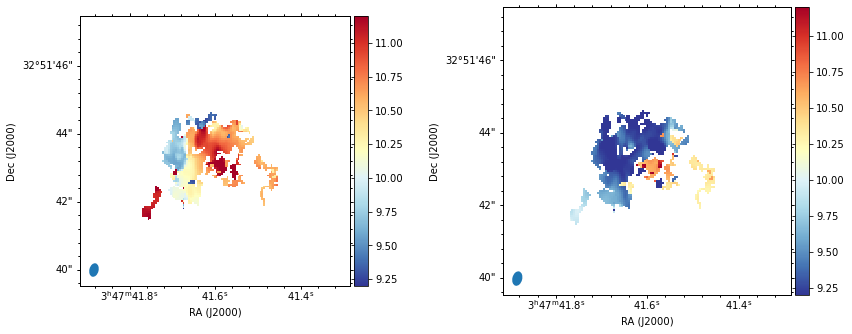

In [18]:
# just to check the different components
fig = plt.figure(figsize=(8,4))
gc = aplpy.FITSFigure(fits.PrimaryHDU(cube.parcube[1], hdcube), figure=fig, subplot=[0,0, 0.5, 1])
gc.show_colorscale(cmap='RdYlBu_r', vmin=9.2, vmax=11.2)
gc.add_colorbar()
gc.add_beam()
gc.recenter(ra_yso, dec_yso, 1200/dist_B5.value/3600)

gc2 = aplpy.FITSFigure(fits.PrimaryHDU(cube.parcube[4], hdcube), figure=fig, subplot=[0.5,0, 1, 1])
gc2.show_colorscale(cmap='RdYlBu_r', vmin=9.2, vmax=11.2)
gc2.add_colorbar()
gc2.add_beam()
gc2.recenter(ra_yso, dec_yso, 1200/dist_B5.value/3600)


## 3 Gaussian fit

It might be an exageration but some might be well fitted with 3 Gaussians. Check afterwards if this is an effect of missing scales in the central channels or not

In [19]:
snratio = 5

imagefilecorr = imagefile + '_contcorrected'
imagefilecontinuum = imagefile + '_continuum.fits'
fitfile3G =  imagefilecorr + '_3G_fitparams.fits'
fitfile3Gfiltered =  imagefilecorr + '_3G_fitparams_filtered.fits'
initguessfile3G = fitfile3Gfiltered
newguessfile3G = imagefilecorr + '_3G_fitparams_guesses.fits'
fitfile23G = imagefilecorr + '_3G_fitparams_2.fits'
fitfile23Gfiltered = imagefilecorr + '_3G_fitparams_2_filtered.fits'
fitfile23GfilteredTpeak = imagefilecorr + '_3G_fitparams_2_filtered_Tpeak.fits'
fitfile23GfilteredVlsr = imagefilecorr + '_3G_fitparams_2_filtered_Vlsr.fits'
fitfile23GfilteredSigmaV = imagefilecorr + '_3G_fitparams_2_sigmafiltered_SigmaV.fits'

### First fit: initial guesses fixed

In [20]:
# initial guesses for the first two gaussian fit
initguesses = [10.0, 11.3, 0.3, 10, 10.7, 0.3, 5.0, 9.5, 0.3]
limitedmin = [True, True, True, True, True, True, True, True, True]
limitedmax = [False, True, True, False, True, True, False, True, True]
limitsmin = [2, velinit, 0.08, 2, velinit, 0.08, 2, velinit, 0.08]
limitsmax = [0, velend, 1, 0, velend, 1, 0, velend, 1]
if not os.path.exists(fitfile3G):
    print("Starting 3G fit")
    cube.fiteach(fittype='gaussian',
                 guesses=initguesses,
                 signal_cut=snratio,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile3G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit exists. Loading")
    cube.load_model_fit(fitfile3G, 3, npeaks=3, fittype='gaussian')

Fit exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


I checked it quickly and it has good solutions in the central region. Let's filter the solutions

### Second fit: extrapolation of obtained solutions

In [25]:
# we apply the filter
if not os.path.exists(fitfile3Gfiltered):
    print("Creating filtered version of initial guesses.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 3, rmsmap=rmsmap, snratio=3, velinit=velinit, velend=velend, filter_negative=True, errorfrac=0.5)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile3Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading filtered version.")
    cube.load_model_fit(fitfile3Gfiltered, 3, npeaks=3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    
if not os.path.exists(newguessfile3G):
    print("Interpolating previous 3 Gaussian solutions.")
    newinitguess3G, headerguess3G = interpolatesolutions(initguessfile3G, 3, mask=planemask)
    newinitguess3G[2][np.where(newinitguess3G[2]>=1)] = 0.9
    newinitguess3G[5][np.where(newinitguess3G[5]>=1)] = 0.9
    newinitguess3G[8][np.where(newinitguess3G[8]>=1)] = 0.9
    fits.writeto(newguessfile3G, newinitguess3G, headerguess3G)
    
else:
    print("Interpolation exists. Loading.")
    newinitguess = fits.getdata(newguessfile3G)
    
if not os.path.exists(fitfile23G):
    print("Starting 3 Gaussian fit (S/N>3)")
    cube.fiteach(fittype='gaussian',
                 guesses=newinitguess3G,
                 errmap = rmsmap, 
                 maskmap = planemask,
                 limitedmin=limitedmin,
                 limitedmax=limitedmax,
                 minpars=limitsmin,
                 maxpars=limitsmax,
                 use_neighbor_as_guess=True, 
                 start_from_point=starting_point,
                 verbose_level=0,
                 multicore=multicore)
    cube.write_fit(fitfile23G)
    fittedmodel = cube.get_modelcube()
    
else:
    print("Fit 2 exists. Loading")
    cube.load_model_fit(fitfile23G, 3, npeaks=3, fittype='gaussian')

Loading filtered version.
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
Interpolation exists. Loading.
Fit 2 exists. Loading
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]
INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,100 [pyspeckit.spectrum.interactive]


NaN or infinite values encountered in parameter cube.
Guesses have been changed from [nan, nan, nan, nan, nan, nan, nan, nan, nan] to [nan, nan, nan, nan, nan, nan, nan, nan, nan]


### Quality assessment of the 3 Gaussian fit

In [26]:
# we apply the filter
if not os.path.exists(fitfile23Gfiltered):
    print("Creating filtered version of the 3 Gaussian fit.")
    parcube, errcube = filtersolutions(cube.parcube, cube.errcube, 3, rmsmap=rmsmap, snratio=2, velinit=velinit, velend=velend, filter_negative=True, errorfrac=0.8, filter_islands=True, minsizetrim=5)
    cube.parcube = parcube
    cube.errcube = errcube
    cube.write_fit(fitfile23Gfiltered)
    fittedmodel = cube.get_modelcube()
        
else:
    print("Loading 2 Gaussian filtered version.")
    cube.load_model_fit(fitfile23Gfiltered, 3, npeaks=3, fittype='gaussian')
    fittedmodel = cube.get_modelcube()
    

Creating filtered version of the 3 Gaussian fit.


invalid value encountered in true_divide
